In [145]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta

import pandas as pd

import scipy.stats as scs

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import fix_yahoo_finance as yf 

%matplotlib inline

In [129]:
# Time Series plot function (http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=0.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# Time Series

## Autoregressive Moving Average $ARMA(p, q)$

\begin{equation}
x_t = c + \varepsilon_t + \sum_{i=1}^p \varphi_i x_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i}
\end{equation}

In [130]:
# ARMA(p, q)
class ARMA:
    
    def __init__(self, p, q, x_0, phi=None, theta=None):
        self.p = p
        self.q = q
        self.x = np.array([x_0])
        self.eps = np.array([0.0])
        self.size = 1
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.mu = 0
        self.sig = 0
    
    def set_phi(self, phi):
        self.phi = phi
        
    def set_theta(self, theta):
        self.theta = theta
    
    def set_noise(self, mu, sig):
        self.eps_mu = mu
        self.eps_sig = sig
    
    def run(self, N):
        # Test p q orders
        if np.size(self.phi) != self.p or np.size(self.theta) != self.q:
            print("Order mismatch")
            return None
        if self.p == 0:
            self.p = 1
            self.phi = np.array([0.0])
        if self.q == 0:
            self.q = 1
            self.theta = np.array([0.0])
        # Add tails
        tail_x = self.p - self.size
        tail_eps = self.q - self.size
        if tail_x > 0:
            self.x = np.insert(self.x, 0, np.zeros(tail_x), axis=0)
        if tail_eps > 0:
            self.eps = np.insert(self.eps, 0, np.zeros(tail_eps), axis=0)
        # Generate noise
        self.eps = np.append(self.eps, np.random.normal(self.eps_mu, self.eps_sig, N))
        # Advance time series
        for t in range(-N, 0):
            x_new = np.dot(self.phi, self.x[-self.p:]) + np.dot(self.theta, self.eps[t-self.q:t]) + self.eps[t]
            self.x = np.append(self.x, x_new)
        # Remove tail
        if tail_x > 0:
            self.x = self.x[tail_x:]
        if tail_eps > 0:
            self.eps = self.eps[tail_eps:]
    
    def plot(self, lags=None):
        tsplot(self.x, lags)
        #plt.figure(figsize=(10,5))
        #plt.plot(self.x)
        #plt.show()

x_0 =  -3.3604063157039543
phi =  [-0.42475162 -0.82368098]
theta =  [0.28029639 0.31033142]


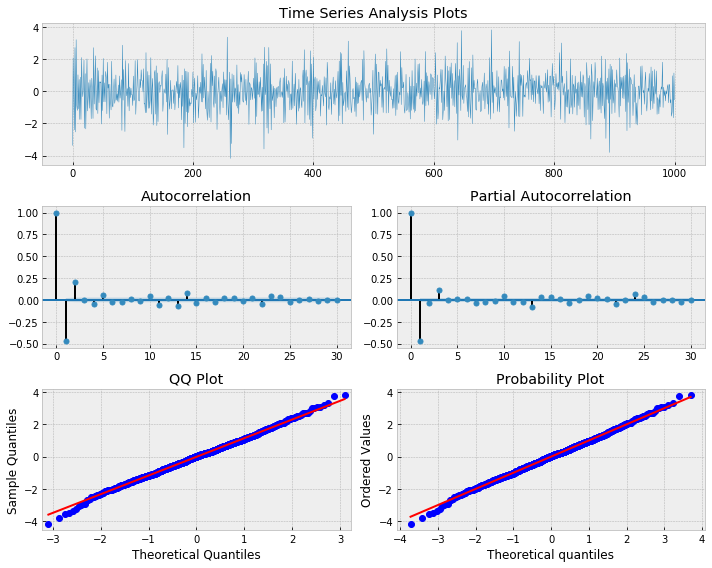

In [135]:
p = 2
q = 2
x_0 = np.random.normal(0, 10)
phi = np.random.normal(0, 1, p)
theta = np.random.normal(0, 1, q)
print('x_0 = ', x_0)
print('phi = ', phi)
print('theta = ', theta)

N = int(1000)

model = ARMA(p, q, x_0, phi, theta)
model.set_noise(0.0, 1.0)
model.run(N)
model.plot(30)

# Markowitz modern portfolio theory

In [180]:
yesterday = (date.today() - timedelta(1)).strftime('%Y-%m-%d')

# Fetch data
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'ETH-USD']
init_date = '2017-01-01'
final_date = yesterday

asset_data = yf.download(tickers, init_date, final_date)
print(asset_data.Close)

[*********************100%***********************]  4 of 4 downloaded


ValueError: zero-size array to reduction operation maximum which has no identity

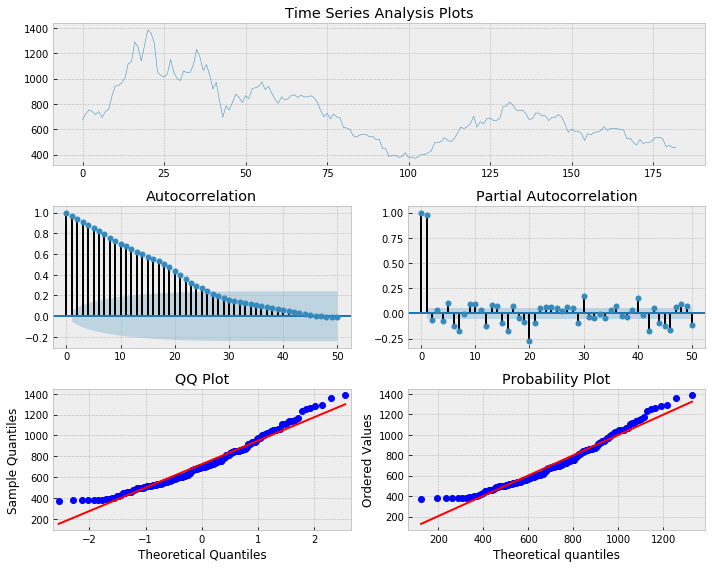

In [195]:
eth = data.Close['ETH-USD'].values
eth = eth[-183:]
tsplot(eth, lags=50)